# Import 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import random_split, ConcatDataset

# Loading data

In [2]:
train_size = 49000
val_size =  9800
test_size = 21000
batch_size=512
random_seed = 42
torch.cuda.is_available()

True

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
full_DS = ConcatDataset([dataset,testset])

torch.manual_seed(random_seed);
train_ds, testset = random_split(full_DS, [train_size, test_size])
train_ds, val_ds = random_split(train_ds, [train_size-val_size, val_size])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
len(train_ds), len(val_ds), len(testset)

(39200, 9800, 21000)

# Models

In [4]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images) 
        criteria = nn.MSELoss()
        loss = criteria(out, images) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        
        criteria = nn.MSELoss()
        loss = criteria(out, images)  # Calculate loss
        # acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        # batch_accs = [x['val_acc'] for x in outputs]
        # epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [5]:
class Autoencoder128(ImageClassificationBase):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
class Autoencoder64(ImageClassificationBase):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
class Autoencoder32(ImageClassificationBase):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(16, 32, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
class Autoencoder16(ImageClassificationBase):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(8, 16, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Helper functions

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(question_no,epochs, lr, model, train_loader, val_loader, opt_func,sch_func,sgd_param=False):
    history = []
    if sgd_param == False:
        optimizer = opt_func(model.parameters(), lr)
    else:
         optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    # optimizer = opt_func(model.parameters(), lr)
    scheduler = sch_func(optimizer, step_size=1000, gamma=0.8)
    val_loss = 99999999999999999
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if (val_loss > history[-1]["val_loss"]):
            torch.save(model.state_dict(), question_no)
            print("saving model for", question_no)
            val_loss = history[-1]["val_loss"]
    return history
def test_accuracy(model, test_loader):
    result = evaluate(model, test_loader)    
    return result["val_loss"]

In [8]:
def fitall(question_no,epochs, lr, model, train_loader, val_loader, opt_func,sch_func,sgd_param=False):
    history = []
    if sgd_param == False:
        optimizer = opt_func(model.parameters(), lr)
    else:
         optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    scheduler = sch_func(optimizer, step_size=1000, gamma=0.8)

    val_loss = 99999999999999999
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if (val_loss > history[-1]["val_loss"]):
            torch.save(model.state_dict(), question_no)
            # print("saving model for", question_no)
            val_loss = history[-1]["val_loss"]
    return history

In [9]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


# Optimisers

In [10]:
num_epochs = 15
scheduler = torch.optim.lr_scheduler.StepLR
lr = 0.001

### Adam Optimizer

In [11]:
model_adam128 = to_device(Autoencoder128(), device);
history_adam16 = fit("adam128",num_epochs, lr, model_adam128, train_dl, val_dl, torch.optim.Adam,scheduler)


Epoch [0], train_loss: 0.0922, val_loss: 0.0676
saving model for adam128
Epoch [1], train_loss: 0.0544, val_loss: 0.0349
saving model for adam128
Epoch [2], train_loss: 0.0236, val_loss: 0.0164
saving model for adam128
Epoch [3], train_loss: 0.0130, val_loss: 0.0106
saving model for adam128
Epoch [4], train_loss: 0.0092, val_loss: 0.0082
saving model for adam128
Epoch [5], train_loss: 0.0074, val_loss: 0.0069
saving model for adam128
Epoch [6], train_loss: 0.0062, val_loss: 0.0059
saving model for adam128
Epoch [7], train_loss: 0.0055, val_loss: 0.0053
saving model for adam128
Epoch [8], train_loss: 0.0049, val_loss: 0.0048
saving model for adam128
Epoch [9], train_loss: 0.0045, val_loss: 0.0044
saving model for adam128
Epoch [10], train_loss: 0.0041, val_loss: 0.0041
saving model for adam128
Epoch [11], train_loss: 0.0039, val_loss: 0.0039
saving model for adam128
Epoch [12], train_loss: 0.0036, val_loss: 0.0037
saving model for adam128
Epoch [13], train_loss: 0.0034, val_loss: 0.0035

In [12]:
model_adam128.load_state_dict(torch.load("adam128"))
print("Loss for test ", test_accuracy(model_adam128,test_dl))

Loss for test  0.003345879027619958


In [13]:
model_adam16 = to_device(Autoencoder16(), device);
model_adam32 = to_device(Autoencoder32(), device);
model_adam64 = to_device(Autoencoder64(), device);
model_adam128 = to_device(Autoencoder128(), device);
hidden = [16,32,64,128]
valloss = []
trainloss = []
history_adam16 = fitall("adam16",5, lr, model_adam16, train_dl, val_dl, torch.optim.Adam,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(16,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam32, train_dl, val_dl, torch.optim.Adam,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(32,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam64, train_dl, val_dl, torch.optim.Adam,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(64,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam128, train_dl, val_dl, torch.optim.Adam,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(128,loss_train/5,loss_val/5))



Epoch [0], train_loss: 0.1833, val_loss: 0.0993
Epoch [1], train_loss: 0.0774, val_loss: 0.0717
Epoch [2], train_loss: 0.0706, val_loss: 0.0701
Epoch [3], train_loss: 0.0693, val_loss: 0.0689
Epoch [4], train_loss: 0.0682, val_loss: 0.0678
Hidden Neurons: 16 	Training Loss: 0.093766 	Validation Loss: 0.075554
Epoch [0], train_loss: 0.1226, val_loss: 0.0719
Epoch [1], train_loss: 0.0700, val_loss: 0.0691
Epoch [2], train_loss: 0.0683, val_loss: 0.0679
Epoch [3], train_loss: 0.0673, val_loss: 0.0670
Epoch [4], train_loss: 0.0651, val_loss: 0.0617
Hidden Neurons: 32 	Training Loss: 0.078661 	Validation Loss: 0.067506
Epoch [0], train_loss: 0.1167, val_loss: 0.0715
Epoch [1], train_loss: 0.0671, val_loss: 0.0602
Epoch [2], train_loss: 0.0440, val_loss: 0.0319
Epoch [3], train_loss: 0.0250, val_loss: 0.0200
Epoch [4], train_loss: 0.0174, val_loss: 0.0154
Hidden Neurons: 64 	Training Loss: 0.054049 	Validation Loss: 0.039810
Epoch [0], train_loss: 0.0977, val_loss: 0.0685
Epoch [1], train_lo

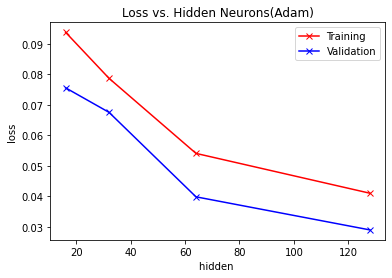

In [17]:
plt.plot(hidden,trainloss, '-rx')
plt.plot(hidden,valloss, '-bx')
plt.ylabel('loss')
plt.xlabel('hidden ')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. Hidden Neurons(Adam)');
# plt.ylim([-0.002,0.15])

### RMSProp Optmizer

In [18]:
model_rms128 = to_device(Autoencoder128(), device);
history_rms128 = fit("rms128",num_epochs, lr, model_rms128, train_dl, val_dl, torch.optim.RMSprop,scheduler)


Epoch [0], train_loss: 0.0727, val_loss: 0.0527
saving model for rms128
Epoch [1], train_loss: 0.0387, val_loss: 0.0285
saving model for rms128
Epoch [2], train_loss: 0.0243, val_loss: 0.0187
saving model for rms128
Epoch [3], train_loss: 0.0175, val_loss: 0.0145
saving model for rms128
Epoch [4], train_loss: 0.0137, val_loss: 0.0124
saving model for rms128
Epoch [5], train_loss: 0.0115, val_loss: 0.0111
saving model for rms128
Epoch [6], train_loss: 0.0100, val_loss: 0.0099
saving model for rms128
Epoch [7], train_loss: 0.0089, val_loss: 0.0084
saving model for rms128
Epoch [8], train_loss: 0.0079, val_loss: 0.0078
saving model for rms128
Epoch [9], train_loss: 0.0072, val_loss: 0.0066
saving model for rms128
Epoch [10], train_loss: 0.0067, val_loss: 0.0063
saving model for rms128
Epoch [11], train_loss: 0.0061, val_loss: 0.0062
saving model for rms128
Epoch [12], train_loss: 0.0058, val_loss: 0.0052
saving model for rms128
Epoch [13], train_loss: 0.0047, val_loss: 0.0048
saving model

In [19]:
model_rms128.load_state_dict(torch.load("rms128"))
print("Loss for test ", test_accuracy(model_rms128,test_dl))

Loss for test  0.004742454271763563


In [20]:
model_adam16 = to_device(Autoencoder16(), device);
model_adam32 = to_device(Autoencoder32(), device);
model_adam64 = to_device(Autoencoder64(), device);
model_adam128 = to_device(Autoencoder128(), device);
hidden = [16,32,64,128]
valloss = []
trainloss = []
history_adam16 = fitall("adam16",5, lr, model_adam16, train_dl, val_dl, torch.optim.RMSprop,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(16,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam32, train_dl, val_dl, torch.optim.RMSprop,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(32,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam64, train_dl, val_dl, torch.optim.RMSprop,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(64,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam128, train_dl, val_dl, torch.optim.RMSprop,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(128,loss_train/5,loss_val/5))



Epoch [0], train_loss: 0.1142, val_loss: 0.0718
Epoch [1], train_loss: 0.0696, val_loss: 0.0678
Epoch [2], train_loss: 0.0663, val_loss: 0.0655
Epoch [3], train_loss: 0.0630, val_loss: 0.0599
Epoch [4], train_loss: 0.0556, val_loss: 0.0518
Hidden Neurons: 16 	Training Loss: 0.073761 	Validation Loss: 0.063353
Epoch [0], train_loss: 0.0761, val_loss: 0.0581
Epoch [1], train_loss: 0.0490, val_loss: 0.0411
Epoch [2], train_loss: 0.0364, val_loss: 0.0320
Epoch [3], train_loss: 0.0290, val_loss: 0.0268
Epoch [4], train_loss: 0.0243, val_loss: 0.0236
Hidden Neurons: 32 	Training Loss: 0.042964 	Validation Loss: 0.036302
Epoch [0], train_loss: 0.0706, val_loss: 0.0487
Epoch [1], train_loss: 0.0373, val_loss: 0.0285
Epoch [2], train_loss: 0.0255, val_loss: 0.0215
Epoch [3], train_loss: 0.0192, val_loss: 0.0170
Epoch [4], train_loss: 0.0155, val_loss: 0.0151
Hidden Neurons: 64 	Training Loss: 0.033632 	Validation Loss: 0.026152
Epoch [0], train_loss: 0.0650, val_loss: 0.0454
Epoch [1], train_lo

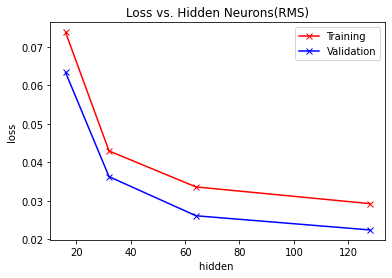

In [21]:
plt.plot(hidden,trainloss, '-rx')
plt.plot(hidden,valloss, '-bx')
plt.ylabel('loss')
plt.xlabel('hidden ')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. Hidden Neurons(RMS)');

### SGD Without Momentum

In [22]:
model_sgd = to_device(Autoencoder128(), device);
history_sgd128 = fit("sgd128",num_epochs, lr, model_sgd, train_dl, val_dl, torch.optim.SGD,scheduler)


Epoch [0], train_loss: 0.1970, val_loss: 0.1960
saving model for sgd128
Epoch [1], train_loss: 0.1950, val_loss: 0.1940
saving model for sgd128
Epoch [2], train_loss: 0.1931, val_loss: 0.1921
saving model for sgd128
Epoch [3], train_loss: 0.1911, val_loss: 0.1901
saving model for sgd128
Epoch [4], train_loss: 0.1892, val_loss: 0.1883
saving model for sgd128
Epoch [5], train_loss: 0.1874, val_loss: 0.1865
saving model for sgd128
Epoch [6], train_loss: 0.1856, val_loss: 0.1847
saving model for sgd128
Epoch [7], train_loss: 0.1838, val_loss: 0.1829
saving model for sgd128
Epoch [8], train_loss: 0.1821, val_loss: 0.1812
saving model for sgd128
Epoch [9], train_loss: 0.1804, val_loss: 0.1796
saving model for sgd128
Epoch [10], train_loss: 0.1788, val_loss: 0.1780
saving model for sgd128
Epoch [11], train_loss: 0.1772, val_loss: 0.1764
saving model for sgd128
Epoch [12], train_loss: 0.1756, val_loss: 0.1748
saving model for sgd128
Epoch [13], train_loss: 0.1742, val_loss: 0.1736
saving model

In [23]:
model_sgd.load_state_dict(torch.load("sgd128"))
print("Loss for test ", test_accuracy(model_sgd,test_dl))

Loss for test  0.17235520482063293


In [24]:
model_adam16 = to_device(Autoencoder16(), device);
model_adam32 = to_device(Autoencoder32(), device);
model_adam64 = to_device(Autoencoder64(), device);
model_adam128 = to_device(Autoencoder128(), device);
hidden = [16,32,64,128]
valloss = []
trainloss = []
history_adam16 = fitall("adam16",5, lr, model_adam16, train_dl, val_dl, torch.optim.SGD,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(16,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam32, train_dl, val_dl, torch.optim.SGD,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(32,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam64, train_dl, val_dl, torch.optim.SGD,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(64,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam128, train_dl, val_dl, torch.optim.SGD,scheduler)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(128,loss_train/5,loss_val/5))



Epoch [0], train_loss: 0.2927, val_loss: 0.2907
Epoch [1], train_loss: 0.2890, val_loss: 0.2869
Epoch [2], train_loss: 0.2852, val_loss: 0.2832
Epoch [3], train_loss: 0.2816, val_loss: 0.2796
Epoch [4], train_loss: 0.2780, val_loss: 0.2760
Hidden Neurons: 16 	Training Loss: 0.285294 	Validation Loss: 0.283296
Epoch [0], train_loss: 0.2315, val_loss: 0.2301
Epoch [1], train_loss: 0.2288, val_loss: 0.2274
Epoch [2], train_loss: 0.2262, val_loss: 0.2249
Epoch [3], train_loss: 0.2237, val_loss: 0.2223
Epoch [4], train_loss: 0.2212, val_loss: 0.2198
Hidden Neurons: 32 	Training Loss: 0.226281 	Validation Loss: 0.224912
Epoch [0], train_loss: 0.1882, val_loss: 0.1872
Epoch [1], train_loss: 0.1863, val_loss: 0.1854
Epoch [2], train_loss: 0.1845, val_loss: 0.1836
Epoch [3], train_loss: 0.1827, val_loss: 0.1818
Epoch [4], train_loss: 0.1810, val_loss: 0.1801
Hidden Neurons: 64 	Training Loss: 0.184517 	Validation Loss: 0.183605
Epoch [0], train_loss: 0.1831, val_loss: 0.1822
Epoch [1], train_lo

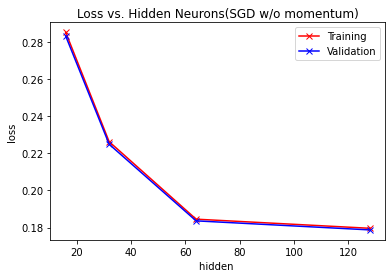

In [25]:
plt.plot(hidden,trainloss, '-rx')
plt.plot(hidden,valloss, '-bx')
plt.ylabel('loss')
plt.xlabel('hidden ')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. Hidden Neurons(SGD w/o momentum)');

### SGD Without Momentum

In [26]:
model_sgd = to_device(Autoencoder128(), device);
history_sgd128 = fit("sgd128",num_epochs, lr, model_sgd, train_dl, val_dl, torch.optim.SGD,scheduler,True)


Epoch [0], train_loss: 0.2032, val_loss: 0.1921
saving model for sgd128
Epoch [1], train_loss: 0.1831, val_loss: 0.1747
saving model for sgd128
Epoch [2], train_loss: 0.1677, val_loss: 0.1610
saving model for sgd128
Epoch [3], train_loss: 0.1555, val_loss: 0.1503
saving model for sgd128
Epoch [4], train_loss: 0.1458, val_loss: 0.1417
saving model for sgd128
Epoch [5], train_loss: 0.1382, val_loss: 0.1349
saving model for sgd128
Epoch [6], train_loss: 0.1319, val_loss: 0.1293
saving model for sgd128
Epoch [7], train_loss: 0.1269, val_loss: 0.1247
saving model for sgd128
Epoch [8], train_loss: 0.1227, val_loss: 0.1209
saving model for sgd128
Epoch [9], train_loss: 0.1192, val_loss: 0.1178
saving model for sgd128
Epoch [10], train_loss: 0.1163, val_loss: 0.1151
saving model for sgd128
Epoch [11], train_loss: 0.1138, val_loss: 0.1129
saving model for sgd128
Epoch [12], train_loss: 0.1117, val_loss: 0.1109
saving model for sgd128
Epoch [13], train_loss: 0.1101, val_loss: 0.1096
saving model

In [27]:
model_sgd.load_state_dict(torch.load("sgd128"))
print("Loss for test ", test_accuracy(model_sgd,test_dl))

Loss for test  0.10820050537586212


In [35]:
model_adam16 = to_device(Autoencoder16(), device);
model_adam32 = to_device(Autoencoder32(), device);
model_adam64 = to_device(Autoencoder64(), device);
model_adam128 = to_device(Autoencoder128(), device);
hidden = [16,32,64,128]
valloss = []
trainloss = []
history_adam16 = fitall("adam16",5, lr, model_adam16, train_dl, val_dl, torch.optim.SGD,scheduler,True)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(16,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam32, train_dl, val_dl, torch.optim.SGD,scheduler,True)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(32,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam64, train_dl, val_dl, torch.optim.SGD,scheduler,True)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(64,loss_train/5,loss_val/5))
history_adam16 = fitall("adam16",5, lr, model_adam128, train_dl, val_dl, torch.optim.SGD,scheduler,True)
loss_val = 0
loss_train = 0
for i in history_adam16:
  loss_val += i["val_loss"]
  loss_train += i["train_loss"]
valloss.append(loss_val/5)
trainloss.append(loss_train/5)
print('Hidden Neurons: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(128,loss_train/5,loss_val/5))



Epoch [0], train_loss: 0.2411, val_loss: 0.2276
Epoch [1], train_loss: 0.2157, val_loss: 0.2042
Epoch [2], train_loss: 0.1946, val_loss: 0.1853
Epoch [3], train_loss: 0.1775, val_loss: 0.1701
Epoch [4], train_loss: 0.1639, val_loss: 0.1580
Hidden Neurons: 16 	Training Loss: 0.198561 	Validation Loss: 0.189043
Epoch [0], train_loss: 0.2310, val_loss: 0.2171
Epoch [1], train_loss: 0.2053, val_loss: 0.1941
Epoch [2], train_loss: 0.1849, val_loss: 0.1764
Epoch [3], train_loss: 0.1694, val_loss: 0.1627
Epoch [4], train_loss: 0.1571, val_loss: 0.1518
Hidden Neurons: 32 	Training Loss: 0.189540 	Validation Loss: 0.180404
Epoch [0], train_loss: 0.1770, val_loss: 0.1694
Epoch [1], train_loss: 0.1629, val_loss: 0.1567
Epoch [2], train_loss: 0.1515, val_loss: 0.1467
Epoch [3], train_loss: 0.1425, val_loss: 0.1387
Epoch [4], train_loss: 0.1353, val_loss: 0.1323
Hidden Neurons: 64 	Training Loss: 0.153829 	Validation Loss: 0.148749
Epoch [0], train_loss: 0.2465, val_loss: 0.2302
Epoch [1], train_lo

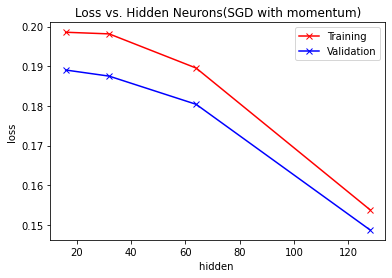

In [41]:
plt.plot(hidden,trainloss, '-rx')
plt.plot(hidden,valloss, '-bx')
plt.ylabel('loss')
plt.xlabel('hidden ')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. Hidden Neurons(SGD with momentum)');

# PCA reconstruction

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.decomposition import PCA


hidden_neuron = [16,32,64,128]


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30, random_state=42)
y_test = y_test.reshape(-1)
y_train = y_train.reshape(-1)

pcaloss = []
loss_encoder = []

print("Loss using PCA")
for i in hidden_neuron:
  pca = PCA(i)
  pca.fit(X_train)
  TRAIN = pca.transform(X_train)
  TEST = pca.transform(X_test)
  approximation = pca.inverse_transform(TEST)
  # print(X_train.shape,approximation.shape)
  loss = mse(approximation,X_test)
  print('Hidden Neurons: {} \tTest Loss: {:.6f}'.format(i,loss))
  pcaloss.append(loss)




Loss using PCA
Hidden Neurons: 16 	Test Loss: 1773.449325
Hidden Neurons: 32 	Test Loss: 1119.145342
Hidden Neurons: 64 	Test Loss: 604.447891
Hidden Neurons: 128 	Test Loss: 280.627940


In [43]:
print("Loss using autoencoder with SGD")
for i,n in enumerate(hidden):
  print("Hidden Neurons :", n , "\tVal Loss: ", valloss[i])

Loss using autoencoder with SGD
Hidden Neurons : 16 	Val Loss:  0.18904260993003846
Hidden Neurons : 32 	Val Loss:  0.18750128149986267
Hidden Neurons : 64 	Val Loss:  0.1804035037755966
Hidden Neurons : 128 	Val Loss:  0.14874915778636932


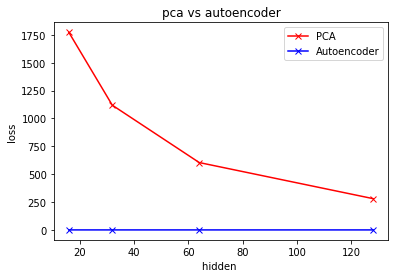

In [49]:
plt.plot(hidden,pcaloss, '-rx')

plt.plot(hidden,valloss, '-bx')
plt.ylabel('loss')
plt.xlabel('hidden ')
plt.legend(['PCA', 'Autoencoder'])
plt.title('pca vs autoencoder');